<a href="https://colab.research.google.com/github/Martinmbiro/Pytorch-computer-vision-basics/blob/main/03%20Modelling%20with%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelling with [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)**
> In this notebook, I'll improve on the concepts we introduced in the previous notebook, and build a simple model with [Convolutional Neural Networks](https://www.datacamp.com/tutorial/introduction-to-convolutional-neural-networks-cnns) (CNN)


> 🔔 **Info**   
> The problem with traditional deep neural networks, like the one we trained in the previous notebook is that they might mis-classify the same image if the image is translated by a few pixels.

> CNNs are the most common architectures used when working working photos / images, and its fundamental building blocks are:
+ Convolutions
+ Filters
+ Strides
+ Pooling

> Here's some useful resources (videos) on the working principle of CNNs
+ [IBM](https://www.youtube.com/watch?v=QzY57FaENXg&pp=ygUdY29udm9sdXRpb25hbCBuZXVyYWwgbmV0d29ya3M%3D)
+ [Code Basics](https://www.youtube.com/watch?v=zfiSAzpy9NM&pp=ygUdY29udm9sdXRpb25hbCBuZXVyYWwgbmV0d29ya3M%3D) 💎
+ [far1din](https://www.youtube.com/watch?v=jDe5BAsT2-Y&pp=ygUdY29udm9sdXRpb25hbCBuZXVyYWwgbmV0d29ya3M%3D) 💎
+ [deeplizard](https://www.youtube.com/watch?v=YRhxdVk_sIs&pp=ygUdY29udm9sdXRpb25hbCBuZXVyYWwgbmV0d29ya3M%3D) 💎

In [ ]:
# imports
import torch, torchvision, matplotlib.pyplot as plt, torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset

# print torch version
print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [ ]:
# set up device
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

# print device
device

'cpu'

### Load the data
> Let's get the data ready
+ I'll re-create the function that returns [`DataLoaders`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for training and testing data from the [`FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST) dataset

In [ ]:
def load_data():
  """A function that returns train_set and test_set DataLoaders
  Returns
  ---
  train_dl
    DataLoader wrapped around the training data
  test_dl
    DataLoader wrapped arond the test data
  """
  # batch size
  BATCH_SIZE = 32

  # train data
  train_data = datasets.FashionMNIST(
      root='data', train=True, download=True, transform=ToTensor())
  # testing data
  test_data = datasets.FashionMNIST(
      root='data', train=False, download=True, transform=ToTensor())

  # train_loader
  train_dl = DataLoader(
      dataset=train_data, shuffle=True, batch_size=BATCH_SIZE)
  # test_laoder
  test_dl = DataLoader(
      dataset=test_data, shuffle=False, batch_size=BATCH_SIZE)

  return train_dl, test_dl

In [ ]:
# get DataLoaders
train_dl, test_dl = load_data()

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 309kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.57MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 20.1MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



#### Visualizing random batch
> Here, I'll take a random batch from the training `DataLoader` and visualize it
+ We'll first convert the training `DataLoader` into a list and use a random index to access a random batch

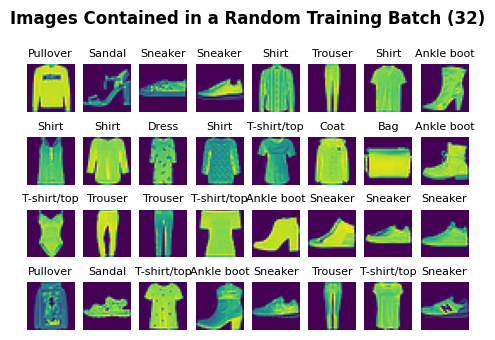

In [ ]:
# generate random index
idx = np.random.randint(low=0, high=len(train_dl))
# get random batch
batch_x, batch_y = list(train_dl)[idx] # convert batch to list

# specify figure and subplots
f, axs = plt.subplots(4, 8, # 4*8 = 32
            figsize=(4.5, 4.5), layout='compressed')
for i, ax in enumerate(axs.flat):
  img, lb = batch_x[i], batch_y[i]
  ax.set_title(train_dl.dataset.classes[lb], fontsize=8)
  ax.axis(False); ax.imshow(img.squeeze())

f.suptitle('Images Contained in a Random Training Batch (32)',
             weight='black',
             y=0.9) #suptitle position
plt.show()

### Build the neural network
> Here, we'll stack two [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) layers, two [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) layers, one [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten) and two [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) for classification. We'll also define the loss function and optimizer
+ Additionally, I'll place [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) after every pooling layer for non-linearity
+ The above will be wrapped in a [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) container
+ I'll use [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) as optimizer and [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#crossentropyloss) as loss function

In [ ]:
def get_model(device):
  """A function that returns a model, optimizer and loss function
  Returns
  ---
  model: torch.nn.Module
    A model built using Conv2d layers

  opt: torch.Optimizer
    An optimizer

  loss_fn: torch.nn.Module
    A loss function for multi-class classification
  """
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  # define model
  model = nn.Sequential(
      # conv-block 1
      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),

      # conv-block 2
      nn.Conv2d(64, 128, 3),
      nn.MaxPool2d(2),
      nn.ReLU(),

      # flatten
      nn.Flatten(),

      # classification block
      nn.Linear(in_features=3200, out_features=256),
      nn.ReLU(),
      nn.Linear(256, 10)
  ).to(device)

  # optimizer
  '''opt = torch.optim.Adam(params=model.parameters(),
                         lr=0.0009) # learning rate'''
  # optimizer
  opt = torch.optim.SGD(
      params=model.parameters(),
      lr=0.01,  # learning rate
      momentum=0.5) #

  # loss_function
  loss_fn = nn.CrossEntropyLoss()

  return model, opt, loss_fn

In [ ]:
# get model, optimizer, loss function
model, opt, loss_fn = get_model(device)

#### Visualize structure of neural network
> We'll do this using the [`torchinfo`](https://github.com/TylerYep/torchinfo) library

In [ ]:
# install torchinfo
!pip install torchinfo
from torchinfo import summary

In [ ]:
# view model structure
summary(model=model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 26, 26]           640
├─MaxPool2d: 1-2                         [1, 64, 13, 13]           --
├─ReLU: 1-3                              [1, 64, 13, 13]           --
├─Conv2d: 1-4                            [1, 128, 11, 11]          73,856
├─MaxPool2d: 1-5                         [1, 128, 5, 5]            --
├─ReLU: 1-6                              [1, 128, 5, 5]            --
├─Flatten: 1-7                           [1, 3200]                 --
├─Linear: 1-8                            [1, 256]                  819,456
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 10.19
Input size (MB): 0.00
Forward

### Early stopping
> 💎 **Pro Tip**

> [Early stopping](https://www.linkedin.com/advice/1/what-benefits-drawbacks-early-stopping#:~:text=Early%20stopping%20is%20a%20form,to%20increase%20or%20stops%20improving.) is a mechanism of stopping training when the validation loss stops improving; with a view to preventing _overfitting_ on the training data
+ Here, we'll create a class to take care of _early-stopping_

In [ ]:
# define a class for early stopping
from copy import deepcopy

class EarlyStopping:
  '''
    patience -> the number of epochs to wait after the last improvement
                before stopping

    counter -> how many epochs have passed since the last improvement

    min_delta -> how much of a difference in loss is to be considered
          worthy to continue training
  '''
  def __init__(self, score_type:str, min_delta:float=0.0, patience:int=5):
    self.counter = 0
    self.patience = patience
    self.min_delta = min_delta
    self.score_type = score_type
    self.best_epoch = None
    self.best_score = None
    self.best_state_dict = None
    self.stop_early = False

    if (self.score_type != 'metric') and (self.score_type != 'loss'):
      err_msg = 'score_type can only be "metric" or "loss"'
      raise Exception(err_msg)

  def __call__(self, model:nn.Module, ep:int, ts_score:float):
    if self.best_epoch is None: # for first time:
      self.best_epoch = ep # store current epoch
      self.best_score = ts_score # store current loss as best loss
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())

    # if previous loss - current loss exceeds min_delta: (for loss function)
    elif (self.best_score - ts_score >= self.min_delta) and (self.score_type == 'loss'):
      self.best_epoch = ep # store current epoch
      self.best_score = ts_score # store current loss as best
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())
      self.counter = 0 # restore counter to zero

    # if current metric - previous. metric exceeds min_delta: (for metric)
    elif (ts_score - self.best_score >= self.min_delta) and (self.score_type == 'metric'):
      self.best_epoch = ep # store current epoch
      self.best_score = ts_score # store current loss as best
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())
      self.counter = 0 # restore counter to zero

    else: # otherwise
      self.counter += 1 # increment counter each time
      if self.counter >= self.patience:
        self.stop_early = True

In [ ]:
# initialize early stopping class
est = EarlyStopping(score_type='loss', patience=3)

### Model training
> First, I'll define functions for training and testing batches, then I'll run an optimization loop

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# function for model training
def train_batches(model:nn.Module, train_dl:torch.utils.data.DataLoader,
                optimizer:torch.optim.Optimizer, device):
  """Trains model on all batches of train-set DataLoader and returns average training loss, accuracy and f1_score

  Returns
  ---
  ls: float
    average training loss across all batches of data
  acc: float
    average training accuracy across all batches of data
  f1: float
    average training f1_score across all batches of data
  """
  # function to train batches of data
  # for reproducability
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)

  ls, f1, acc = 0, 0, 0
  # training-mode
  model.train()
  # loop through each batch in the training DataLoader
  for x, y in train_dl:
    x = x.to(device); y = y.to(device)
    # optimizer zero-grad
    optimizer.zero_grad()
    # forward pass
    logits = model(x)
    y_pred = F.softmax(logits, dim=1).argmax(dim=1).cpu().numpy()
    # accumulate accuracy_score
    acc += accuracy_score(
        y_true=y.cpu().numpy(), # tensor -> numpy
        y_pred=y_pred)

    # accumulate f1_score
    f1 += f1_score(
        y_true=y.cpu().numpy(), # tensor -> numpy
        y_pred=y_pred, average='macro')

    # loss
    loss = loss_fn(logits, y)
    ls += loss.item() # accumulate loss

    # back propagation
    loss.backward()
    # gradient descent
    optimizer.step()

  # average the values
  ls /= len(train_dl)
  f1 /= len(train_dl)
  acc /= len(train_dl)

  return ls, acc, f1

# function to test batches of data
def test_batches(model:nn.Module, test_dl:torch.utils.data.DataLoader,
                device):
  """Evaluates model on all batches of test-set DataLoader and returns average test loss, accuracy and f1_score

  Returns
  ---
  ls: float
      average test loss across all batches of data
  acc: float
      average test accuracy across all batches of data
  f1: float
      average test f1_score across all batches of data
  """
  ls, f1, acc = 0, 0, 0
  # evaluation-mode
  model.eval()

  with torch.inference_mode():
    # loop through each batch in testing DataLoader
    for x, y in test_dl:
      x = x.to(device); y = y.to(device)
      # forward pass
      logits = model(x)
      y_pred = F.softmax(logits, dim=1).argmax(dim=1).cpu().numpy()

      # loss
      ls += loss_fn(logits, y).item()

      # accumulate accuracy
      acc += accuracy_score(
          y_true=y.cpu().numpy(), # tensor -> numpy
          y_pred=y_pred)

      # accumulate f1_score
      f1 += f1_score(
          y_true=y.cpu().numpy(), # tensor -> numpy
          y_pred=y_pred, average='macro')

  # average the values
  ls /= len(test_dl)
  f1 /= len(test_dl)
  acc /= len(test_dl)

  return ls, acc, f1


  # a function that returns prediction labels and prediction probabilities

# a function that returns prediction labels and prediction probabilities
def get_preds_proba(model:torch.nn.Module, test_dl:torch.utils.data.DataLoader):
  """A function that returns y_pred and y_proba from the passed DataLoader

  Parameters
  ---

  model: torch.nn.Module
    A neural network that subclasses torch.nn.Module

  test_dl: torch.utils.data.DataLoader
    A DataLoader for the test dataset

  Returns
  ---
  y_pred:np.ndarray
    A numpy ndarray with prediction labels

  y_proba: np.ndarray
    A numpy ndarray with prediction probabilities
  """
  # get predictions, pred-proba, and convert to numpy array
  with torch.inference_mode():
    pred_list, proba_list = [], []

    model.eval()
    for x, _ in test_dl: # append all prediction tensors into a list
      logits = model.to(device)(x.to(device))

      proba_list.append(F.softmax(logits, dim=1)) # probabilities
      pred_list.append(F.softmax(logits, dim=1).argmax(dim=1)) # predictions

    y_pred = torch.concatenate(pred_list).cpu().numpy()
    y_proba = torch.concatenate(proba_list).cpu().numpy()

  # confirm shape of y_proba and y_pred
  # return y_pred, y_proba
  return y_pred, y_proba

In [ ]:
%%time
# lists to keep progress of training values
train_loss, test_loss, train_f1, test_f1, train_acc, test_acc, ep_list = [],\
    [], [], [], [], [], [],
# epochs
epochs = 40

# optimization loop
for ep in range(1, epochs+1):
  ep_list.append(ep)
  # train
  tr_loss, tr_acc, tr_f1 = train_batches(model, train_dl, opt, device)
  # append the train values returned to respective lists
  train_loss.append(tr_loss), train_acc.append(tr_acc), train_f1.append(tr_f1)

  # test
  ts_loss, ts_acc, ts_f1 = test_batches(model, test_dl, device)
  # append the train values returned to respective lists
  test_loss.append(ts_loss), test_acc.append(ts_acc), test_f1.append(ts_f1)

  # early stopping
  est(model=model, ep=ep, ts_score=ts_loss)
  if est.stop_early:
    break

  if ep%3 == 0:
    print(f'Epoch: {ep}\n----------')
    print(f'Train Loss: {tr_loss:.3f} | Test Loss: {ts_loss:.3f}')
    print(f'Train Accuracy: {tr_acc:.3f} | Test Accuracy: {ts_acc:.3f}')
    print(f'Train F1-Score: {tr_f1:.3f} | Test F1-Score: {ts_f1:.3f}\n')

# print best results
print(f'STOPPED | Best Epoch: {est.best_epoch} | Best Loss: {est.best_score:.3f}')

Epoch: 3
----------
Train Loss: 0.408 | Test Loss: 0.402
Train Accuracy: 0.851 | Test Accuracy: 0.855
Train F1-Score: 0.821 | Test F1-Score: 0.824

Epoch: 6
----------
Train Loss: 0.313 | Test Loss: 0.331
Train Accuracy: 0.885 | Test Accuracy: 0.880
Train F1-Score: 0.860 | Test F1-Score: 0.853

Epoch: 9
----------
Train Loss: 0.266 | Test Loss: 0.300
Train Accuracy: 0.902 | Test Accuracy: 0.893
Train F1-Score: 0.880 | Test F1-Score: 0.868

Epoch: 12
----------
Train Loss: 0.234 | Test Loss: 0.280
Train Accuracy: 0.915 | Test Accuracy: 0.901
Train F1-Score: 0.894 | Test F1-Score: 0.877

Epoch: 15
----------
Train Loss: 0.208 | Test Loss: 0.270
Train Accuracy: 0.924 | Test Accuracy: 0.905
Train F1-Score: 0.905 | Test F1-Score: 0.882

Epoch: 18
----------
Train Loss: 0.184 | Test Loss: 0.263
Train Accuracy: 0.933 | Test Accuracy: 0.908
Train F1-Score: 0.916 | Test F1-Score: 0.886

Epoch: 21
----------
Train Loss: 0.162 | Test Loss: 0.262
Train Accuracy: 0.942 | Test Accuracy: 0.911
Train 

In [ ]:
# overwrite the model parameters with best parameters
model.load_state_dict(est.best_state_dict)

<All keys matched successfully>

In [ ]:
# get prediction labels and probabilities
y_pred, y_proba = get_preds_proba(model, test_dl)

# confirm the size of both
y_pred.shape, y_proba.shape

((10000,), (10000, 10))

### Model evaluation
> Here, I'll evaluate the model by plotting results from the optimization loop, as well as evaluating it on basis of classification metrics  

> ✋ **Info**
+ I'll be using [`scikit-learn`](https://scikit-learn.org/stable/index.html) [classification metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#classification-metrics)

#### Define custom evaluation functions
> Here, I'll define functions to
+ Plot results from optimization loop
+ Plot confusion matrix

In [ ]:
# function to plot train and test results
def plot_train_results(ep_list:list, train_score:list, test_score:list,
                       ylabel, title:str, best_epoch:None):
  """A function that plots train and test results against each other
  """
  f, ax = plt.subplots(figsize=(5, 3), layout='constrained')

  # train loss
  ax.plot(ep_list, train_score, label='Training',
          linewidth=1.7, color='#0047ab')

  # test loss
  ax.plot(ep_list, test_score, label='Validation',
          linewidth=1.7, color='#990000')
  # vertical line (for early stopping)
  if best_epoch is not None:
    ax.axvline(best_epoch, linestyle='--', color='#000000', linewidth=1.0,
             label=f'Best ep ({best_epoch})')

  # axis, title
  ax.set_title(title, weight='black')
  ax.set_ylabel(ylabel)
  ax.set_xlabel('Epoch')
  ax.tick_params(axis='both', labelsize=9)
  plt.grid(color='#e5e4e2')

  # legend
  f.legend(fontsize=9, loc='upper right',
          bbox_to_anchor=(1.28, 0.93),
          fancybox=False)

  plt.show()

In [ ]:
# function to plot confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true:np.ndarray, y_pred:np.ndarray):
  # define figure and plot
  _, ax = plt.subplots(figsize=(4.0,4.0), layout='compressed')
  # plot
  ConfusionMatrixDisplay.from_predictions(
      y_true=y_true,
      y_pred=y_pred, cmap='Blues', colorbar=False, ax=ax)

  # for x and y labels
  ax.set_ylabel('True Labels', weight='black')
  ax.set_xlabel('Predicted Labels', weight='black',
                  color='#dc143c')
  # tick size and position
  ax.xaxis.tick_top()
  ax.xaxis.set_label_position('top')
  ax.tick_params(axis='both', labelsize=9)

  # change annotation font
  for txt in ax.texts:
    txt.set_fontsize(9)

  plt.show()

#### Plot optimization results

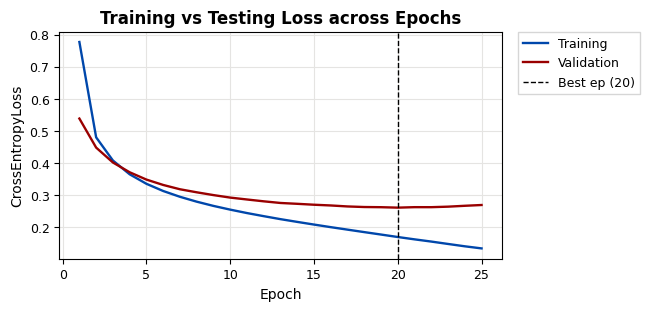

In [ ]:
# training vs testing loss
plot_train_results(ep_list=ep_list, train_score=train_loss, test_score=test_loss,
                   ylabel='CrossEntropyLoss',
                   title='Training vs Testing Loss across Epochs',
                   best_epoch=est.best_epoch)

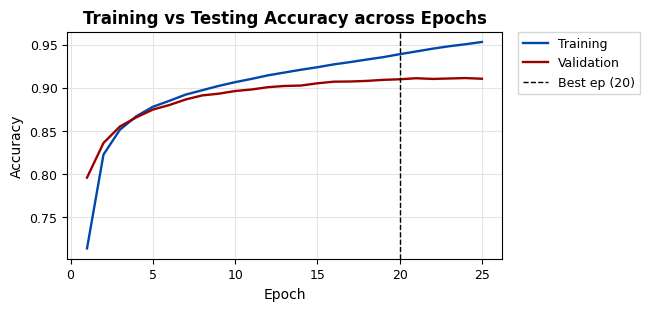

In [ ]:
# training vs testing accuracy
plot_train_results(ep_list=ep_list, train_score=train_acc, test_score=test_acc,
                   ylabel='Accuracy',
                   title='Training vs Testing Accuracy across Epochs',
                   best_epoch=est.best_epoch)

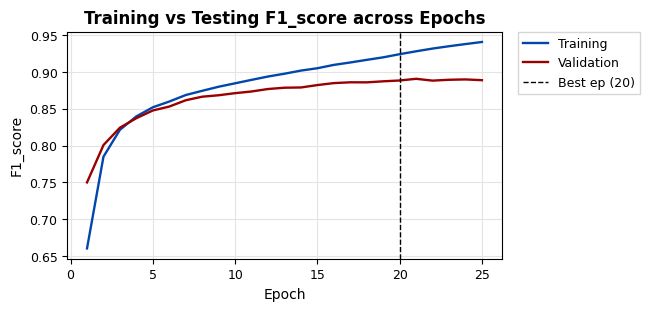

In [ ]:
# training vs testing f1_scores
plot_train_results(ep_list=ep_list, train_score=train_f1, test_score=test_f1,
                   ylabel='F1_score',
                   title='Training vs Testing F1_score across Epochs',
                   best_epoch=est.best_epoch)

#### [`accuracy`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

In [ ]:
# compute accuracy
acc = accuracy_score(
    y_true=test_dl.dataset.targets.cpu().numpy(), #tensor->numpy
    y_pred=y_pred)
# print
print(f'Model Accuracy: {acc:.4f}')

Model Accuracy: 0.9099


#### [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

In [ ]:
# compute f1_score
f1 = f1_score(y_true=test_dl.dataset.targets.cpu().numpy(), #tensor->numpy
                     y_pred=y_pred, average='macro')
# print
print(f'F1_score: {f1:.4f}')

F1_score: 0.9093


#### [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(y_true=test_dl.dataset.targets.cpu().numpy(), #tensor->numpy
                     y_pred=y_pred)
# print
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.88      0.86      1000
           3       0.92      0.92      0.92      1000
           4       0.84      0.88      0.86      1000
           5       0.97      0.98      0.98      1000
           6       0.78      0.70      0.74      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.98      0.98      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



#### [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

In [ ]:
from sklearn.metrics import roc_auc_score
# calculate
ras = roc_auc_score(y_true=test_dl.dataset.targets.cpu().numpy(),
                    y_score=y_proba,
                    multi_class='ovr')
# print
print(f'roc_auc_score: {ras:.3f}')

roc_auc_score: 0.994


#### [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)

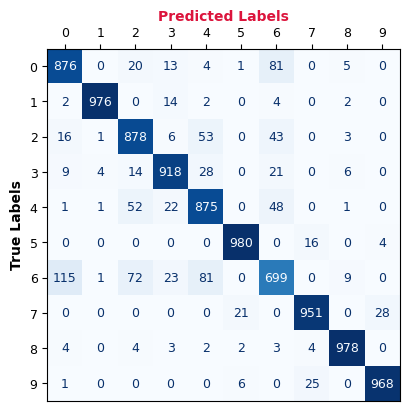

In [ ]:
# plot confusion matrix
plot_confusion_matrix(
    y_true=test_dl.dataset.targets.cpu().numpy(),
    y_pred=y_pred)

In [ ]:
# check the classes again:
test_dl.dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### Conclusion

> 📈 **Results**  

> Based on the overall classification metrics, the model we've trained in this notebook using [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) performs much better than the neural network built using [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) activations in the previous notebook.

> We were able to achieve the following (on a scale of `0` -> `1`):
+ A weighted `precision`, `recall` and `f1_score` of `0.91`
+ An overall model accuracy of `0.9099`
+ An overall `roc_auc_score` of `0.994`

> Compared to the neural network built using `nn.Linear` layers, where we achieved the following (on a scale of `0` -> `1`):
+ A weighted `precision`, `recall` and `f1_score` of `0.86`
+ An overall model accuracy of `0.860`
+ An overall `roc_auc_score` of `0.987`

> Notably however, from the `classification_report` and `confusion_matrix`, the model struggles for classes `0` (`T-shirt/top`), `4` (`Coat`) and `6` (`Shirt`), probably due to the inherent ambiguity between these classes in the dataset

> ▶️ **Up Next**
+ Implementing [`TinyVGG`](https://www.youtube.com/watch?v=HnWIHWFbuUQ) in the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/). Hopefully, we'll get better performance